# Sequentially Comparing Forecasters on Synthetic Data

Here, we plot our time-uniform empirical-Bernstein (EB) and Hoeffding CSs on various synthetic sequential (non-iid, time-varying) forecast comparison scenarios. We also provide comparisons against a fixed-time CI ([Lai et al., 2011](https://doi.org/10.1214/11-AOS902)).

See also: Section 5.1 in our paper.

YJ Choe [yjchoe@cmu.edu]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os.path

import comparecast as cc

## Hyperparameter Settings

In [2]:
# which scoring rule to use
scoring_rule = "brier"

# significance level
alpha = 0.05

# whether to use the log scale on x-axis (time)
use_logx = False

# size up label fonts
font_scale = 1.75

# RNG
rng = np.random.default_rng(1)

## Forecasts on Synthetic Data

The synthetic data as well as the forecasts are generated from the command line via:
```shell
# changepoints evenly spaced in regular scale (default)
python forecast.py -d default -n 10000 -f all -o forecasts/default.csv -p plots/default
```

In [3]:
data_name = "default"
data_file = f"forecasts/{data_name}.csv"
plots_dir = f"plots/{data_name}/{scoring_rule}"

data = cc.data_utils.synthetic.get_data(data_file)
data

,time,y,true_probs,laplace,k29_poly3,k29_rbf0.01,constant_0.5,constant_0,constant_1,random,mix_01_noiseless,mix_01,mix_10_noiseless,mix_10,k29
0,1,0,0.512573,0.500000,0.500000,0.500000,0.5,0.0,1.0,0.737568,0.2,0.488625,0.8,0.558226,0.500000
1,2,0,0.486790,0.250000,0.000000,0.000000,0.5,0.0,1.0,0.520202,0.2,0.440680,0.8,0.000000,0.000000
2,3,1,0.564042,0.166667,0.000000,0.000000,0.5,0.0,1.0,0.246811,0.2,0.000000,0.8,1.000000,0.000000
3,4,1,0.510490,0.375000,0.000000,0.000000,0.5,0.0,1.0,0.559666,0.2,1.000000,0.8,0.701330,0.000000
4,5,1,0.446433,0.500000,1.000000,1.000000,0.5,0.0,1.0,0.903658,0.2,0.000000,0.8,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,0,0.333804,0.503351,0.179688,0.223633,0.5,0.0,1.0,0.065758,0.8,0.559687,0.2,0.000000,0.223633
9996,9997,0,0.155623,0.503301,0.176758,0.222656,0.5,0.0,1.0,0.283446,0.8,0.000000,0.2,0.000000,0.222656
9997,9998,0,0.158363,0.503251,0.174805,0.221680,0.5,0.0,1.0,0.610947,0.8,1.000000,0.2,0.574698,0.221680
9998,9999,0,0.073370,0.503200,0.172852,0.221680,0.5,0.0,1.0,0.162384,0.8,0.000000,0.2,0.000000,0.221680


We also add a few more (data-specific) forecasters that have changepoints and also some noise.

In [4]:
#if "mix_01" not in data:
T = len(data)
noise_level = 0.5
data["mix_01_noiseless"] = np.concatenate([np.repeat(0.2, 6000), np.repeat(0.8, 4000)])
data["mix_01"] = (data["mix_01_noiseless"] + noise_level * rng.standard_t(1, size=T)).clip(0, 1)
data["mix_10_noiseless"] = np.concatenate([np.repeat(0.8, 6000), np.repeat(0.2, 4000)])
data["mix_10"] = (data["mix_10_noiseless"] + noise_level * rng.standard_t(1, size=T)).clip(0, 1)

# Treat 'k29_rbf0.01' as the default k29 forecaster
data["k29"] = data["k29_rbf0.01"]

# overwrite data
data.to_csv(data_file, index=False)

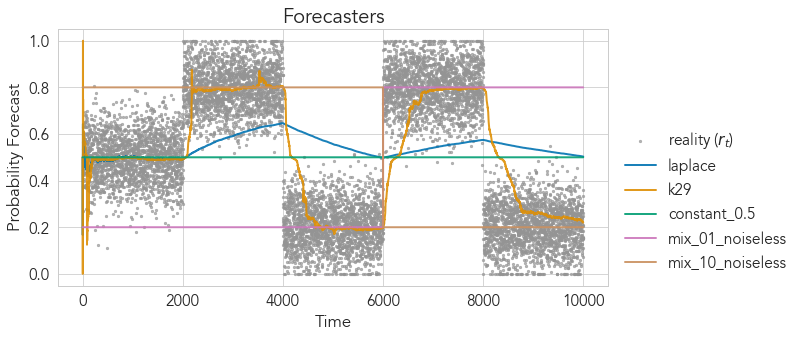

In [5]:
cc.plot_forecasts(
    data, 
    forecasters=["laplace", "k29", "constant_0.5", #"constant_0", "constant_1",
                 "mix_01_noiseless", "mix_10_noiseless"], 
    plots_dir=plots_dir, 
    use_logx=use_logx,
    font_scale=font_scale,
)

## Example 1

In [6]:
name_p, name_q = "mix_10", "mix_01"
results = cc.compare_forecasts(
    data, 
    name_p, 
    name_q, 
    scoring_rule=scoring_rule,
    alpha=alpha,
)
results

,time,lcb,ucb,e_pq,e_qp
0,1,-10.159137,10.013413,0.968611,1.025507
1,2,-4.982469,5.103806,0.999601,0.909882
2,3,-2.988313,3.735871,0.961095,0.445196
3,4,-2.322282,2.838348,0.861821,0.430118
4,5,-1.794132,2.606985,1.033228,0.331078
...,...,...,...,...,...
9995,9996,-0.031806,0.020176,0.005377,0.023844
9996,9997,-0.031803,0.020174,0.005377,0.023844
9997,9998,-0.031734,0.020240,0.005408,0.023544
9998,9999,-0.031731,0.020238,0.005408,0.023544


calculating diagnostics under repeated sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 236.81it/s]


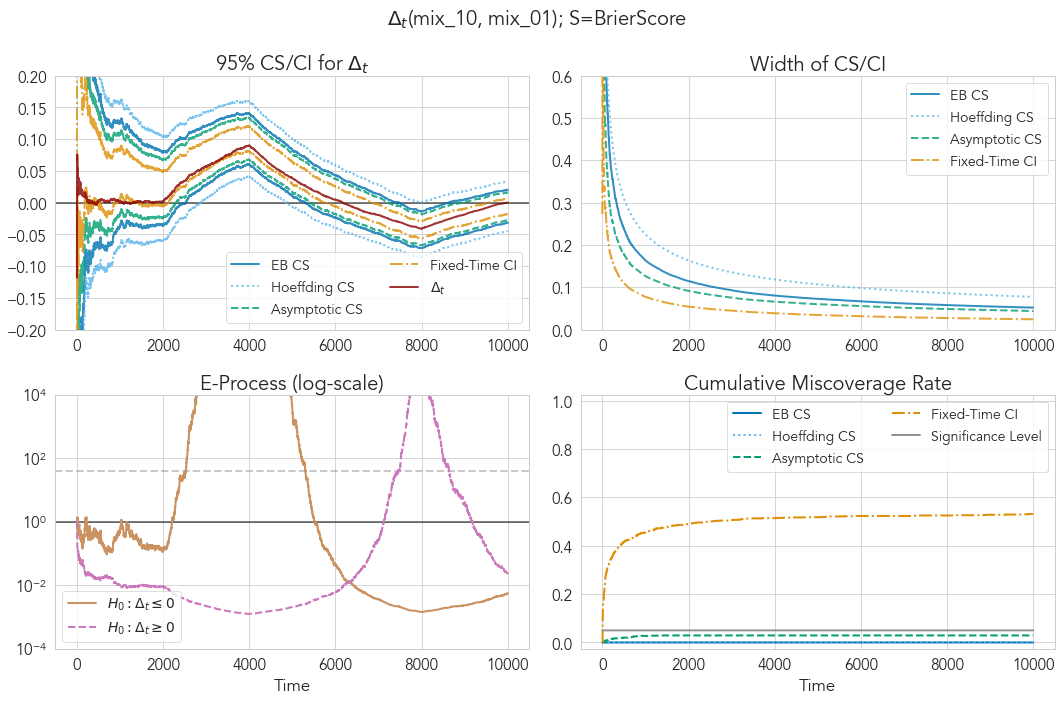

In [7]:
results, axes = cc.plot_comparison(
    data, 
    name_p, 
    name_q, 
    scoring_rule=scoring_rule,    
    plots_dir=plots_dir, 
    alpha=alpha,
    baselines=("h", "acs", "ci"),
    plot_e=True,
    plot_width=True,
    plot_diagnostics=True,
    diagnostics_fn="miscoverage",
    diagnostics_baselines=("h", "acs", "ci"),
    use_logx=use_logx,
    ylim_scale=0.2,
    font_scale=font_scale,
)
axes[0].legend(loc="lower right", fontsize="small", ncol=2)
None

## Example 2

/Users/yjchoe/Dropbox/Code/ComparingForecasters/comparecast/eprocess.py:48: RuntimeWarning: divide by zero encountered in log
  + np.log(gammainc(v_rho_csq, np.maximum(1e-8, cs_v_rho_csq)))
calculating diagnostics under repeated sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 222.49it/s]


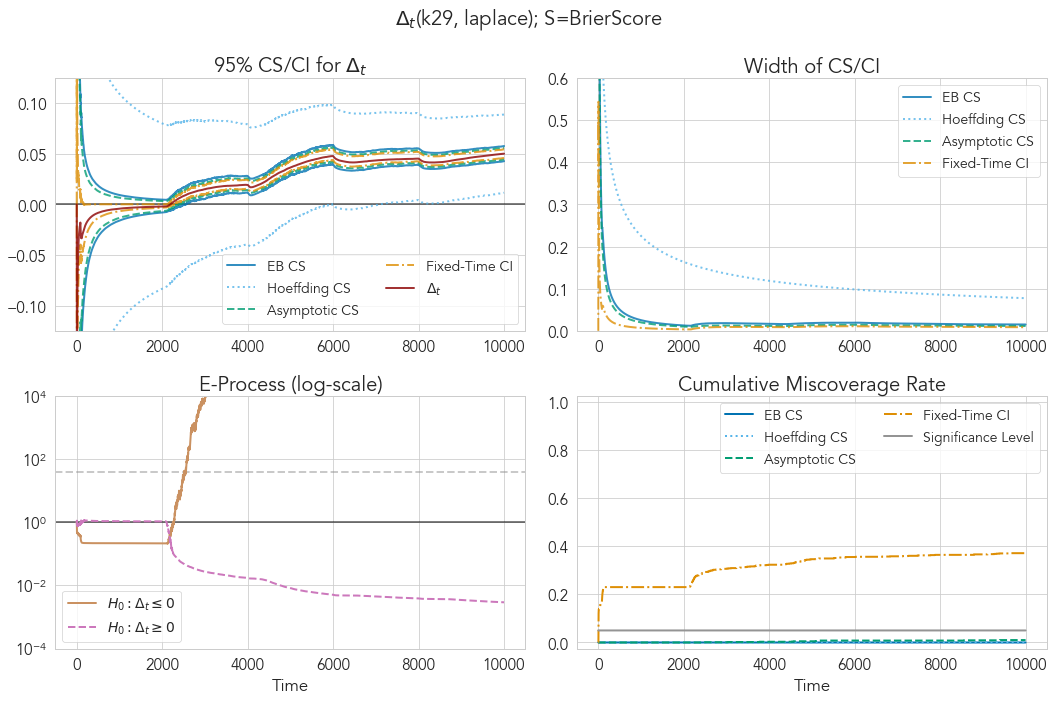

In [8]:
name_p = "k29"
name_q = "laplace"
results, axes = cc.plot_comparison(
    data, 
    name_p, 
    name_q, 
    scoring_rule=scoring_rule,    
    plots_dir=plots_dir, 
    alpha=alpha,
    baselines=("h", "acs", "ci"),
    plot_e=True,
    plot_width=True,
    plot_diagnostics=True,
    diagnostics_fn="miscoverage",
    diagnostics_baselines=("h", "acs", "ci"),
    use_logx=use_logx,
    ylim_scale=0.125,
    font_scale=font_scale,
)
axes[0].legend(loc="lower right", fontsize="small", ncol=2)
None

## Example 3

calculating diagnostics under repeated sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 233.74it/s]


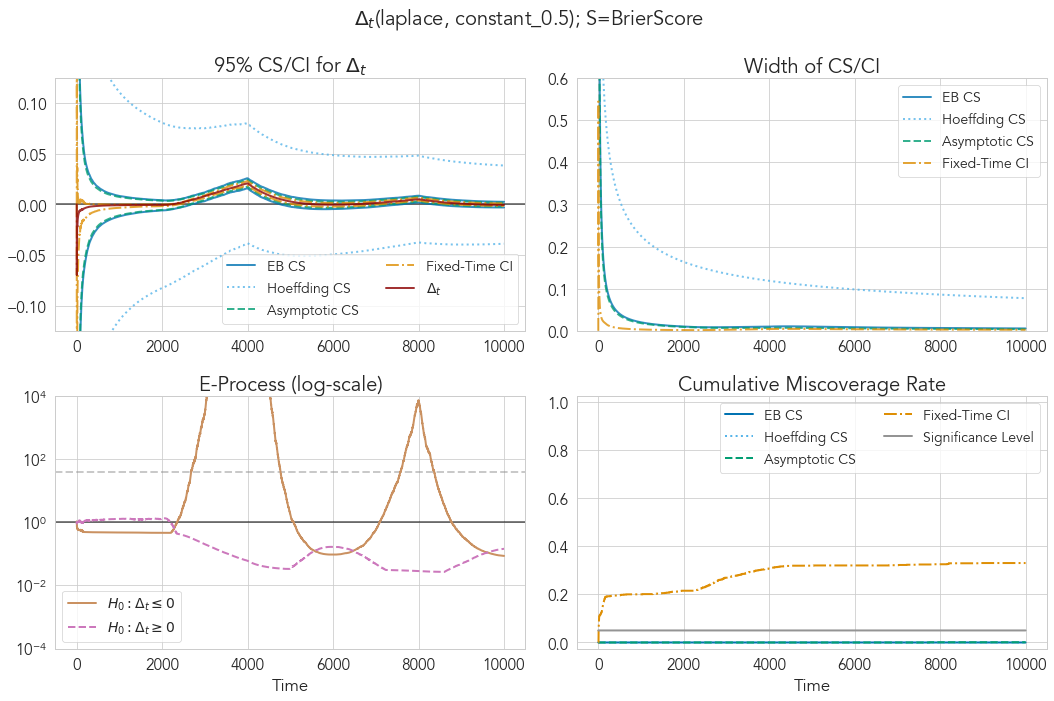

In [9]:
name_p = "laplace"
name_q = "constant_0.5"
results, axes = cc.plot_comparison(
    data, 
    name_p, 
    name_q, 
    scoring_rule=scoring_rule,    
    plots_dir=plots_dir, 
    alpha=alpha,
    baselines=("h", "acs", "ci"),
    plot_e=True,
    plot_width=True,
    plot_diagnostics=True,
    diagnostics_fn="miscoverage",
    diagnostics_baselines=("h", "acs", "ci"),
    use_logx=use_logx,
    ylim_scale=0.125,
    font_scale=font_scale,
)
axes[0].legend(loc="lower right", fontsize="small", ncol=2)
None

## Comparing Many Forecasters

We now compare all pairs between four forecasters for this dataset.

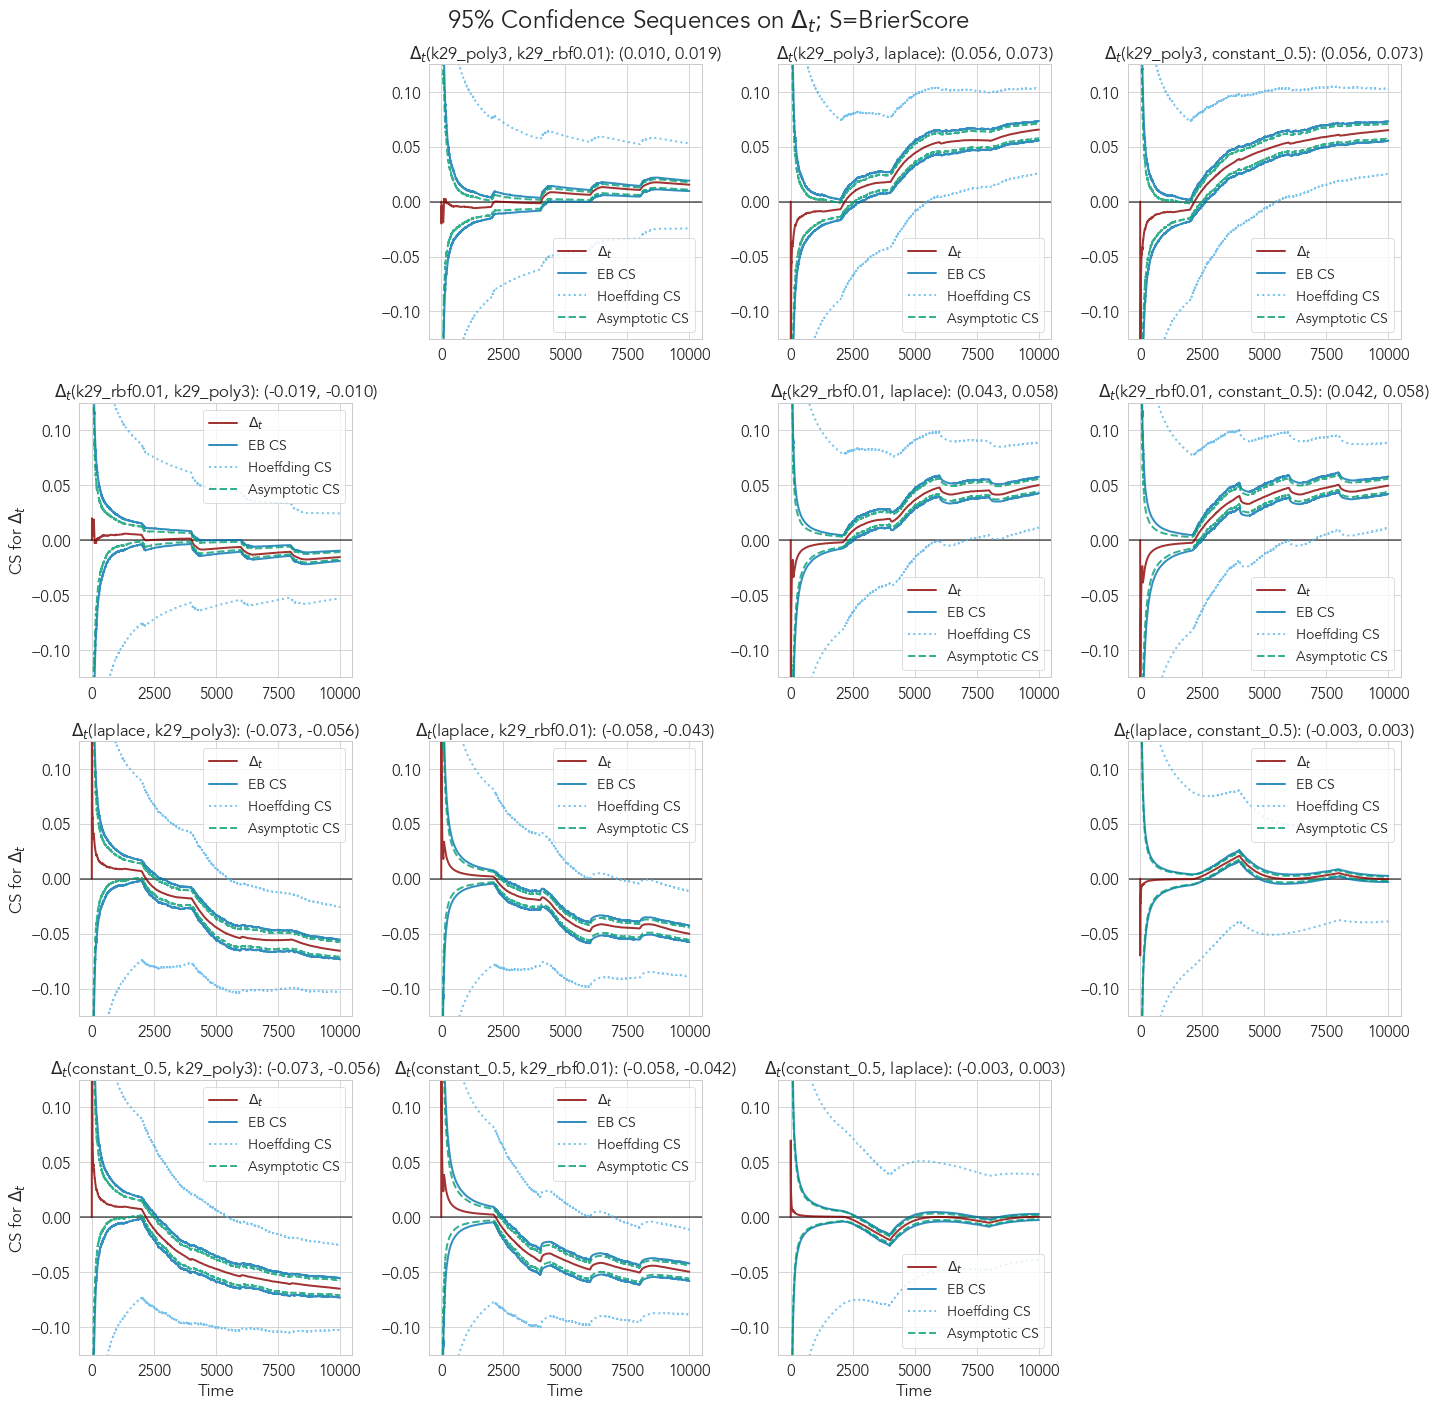

In [10]:
forecasters = ["k29_poly3", "k29_rbf0.01", "laplace", "constant_0.5"]
axes = cc.plot_pairwise_comparisons(
    data,
    forecasters, 
    scoring_rule=scoring_rule,
    plots_dir=plots_dir, 
    alpha=alpha,
    baselines=("h", "acs"),
    use_logx=use_logx,
    ylim_scale=0.125,
    font_scale=font_scale,
)